### Read in data 

In [1]:
data <- read.csv("advertising.csv", header=T)

df <- data.frame(data)
summary(df)

       X                TV             radio          newspaper     
 Min.   :  1.00   Min.   :  0.70   Min.   : 0.000   Min.   :  0.30  
 1st Qu.: 50.75   1st Qu.: 74.38   1st Qu.: 9.975   1st Qu.: 12.75  
 Median :100.50   Median :149.75   Median :22.900   Median : 25.75  
 Mean   :100.50   Mean   :147.04   Mean   :23.264   Mean   : 30.55  
 3rd Qu.:150.25   3rd Qu.:218.82   3rd Qu.:36.525   3rd Qu.: 45.10  
 Max.   :200.00   Max.   :296.40   Max.   :49.600   Max.   :114.00  
     sales      
 Min.   : 1.60  
 1st Qu.:10.38  
 Median :12.90  
 Mean   :14.02  
 3rd Qu.:17.40  
 Max.   :27.00  

In [2]:
# Drop index column
df <- subset(df, select = -X)

### Create train and test sets

In [3]:
# 70/30 split
sample_size <- floor(0.7 * nrow(df))
set.seed(100)
train_index <- sample(seq_len(nrow(df)), size = sample_size)

train <- df[train_index, ]
test <- df[-train_index, ]

### Exploratory plots

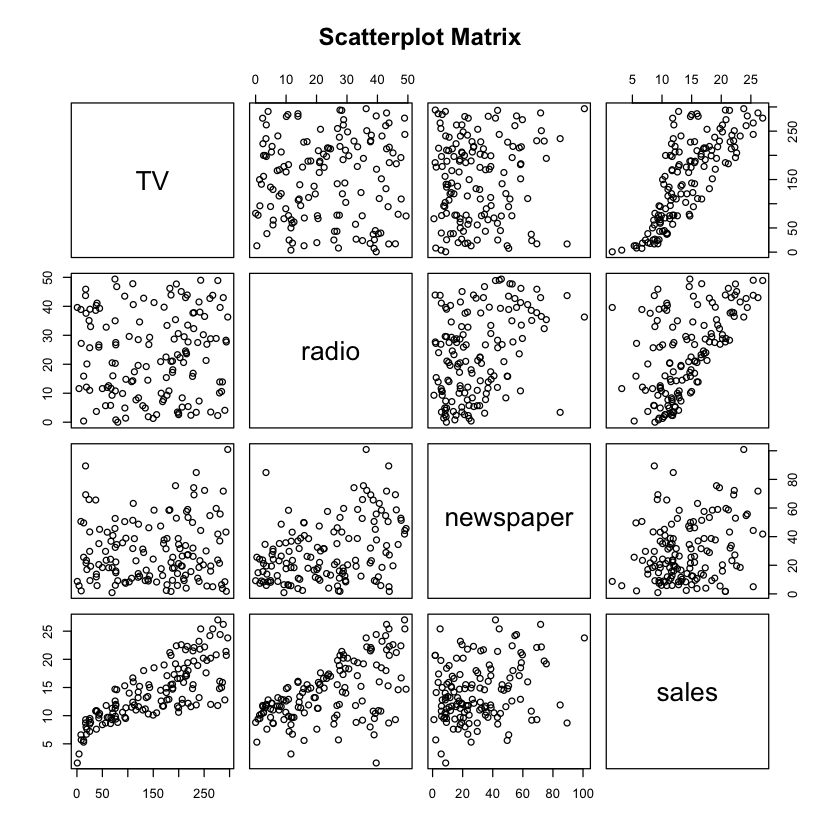

In [4]:
pairs(~.,data=train, main="Scatterplot Matrix")

The plots of TV/radio/newspaper show random scatter, indicating that there is no correlation between these variables.
Each of the sales vs TV/radio/newspaper plots shows a linear relationship, so let's try using a linear model.
The plot of sales vs newspaper and sales vs TV show a fan-shape, indicating heteroskedasticity. 

### Selecting a linear model

#### Choose a linear model using backward elimination.

In [5]:
# Fit model with all explanatory variables                      
fullmodel <- lm(sales~.,data=df)
summary(fullmodel)


Call:
lm(formula = sales ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
radio        0.188530   0.008611  21.893   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


In [6]:
# Drop newspaper
updatedmodel <- update(fullmodel, .~.-newspaper)
summary(updatedmodel)


Call:
lm(formula = sales ~ TV + radio, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.7977 -0.8752  0.2422  1.1708  2.8328 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.92110    0.29449   9.919   <2e-16 ***
TV           0.04575    0.00139  32.909   <2e-16 ***
radio        0.18799    0.00804  23.382   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.681 on 197 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8962 
F-statistic: 859.6 on 2 and 197 DF,  p-value: < 2.2e-16


All explanatory variables have p-value > alpha, so we stop backward elimination here

#### Choose a linear model using all subsets regression

In [14]:
library(leaps)
best.subset <- regsubsets(sales~., data=df, nbest=1)
summary(best.subset)

Subset selection object
Call: regsubsets.formula(sales ~ ., data = df, nbest = 1)
3 Variables  (and intercept)
          Forced in Forced out
TV            FALSE      FALSE
radio         FALSE      FALSE
newspaper     FALSE      FALSE
1 subsets of each size up to 3
Selection Algorithm: exhaustive
         TV  radio newspaper
1  ( 1 ) "*" " "   " "      
2  ( 1 ) "*" "*"   " "      
3  ( 1 ) "*" "*"   "*"      

In [15]:
# Compare C_p values
summary(best.subset)$cp
which.max(summary(best.subset)$cp)

[1] 544.081354   2.031228   4.000000

[1] 1

In [16]:
# Compare adjusted R^2 values
summary(best.subset)$adjr2
which.max(summary(best.subset)$adjr2)

[1] 0.6099148 0.8961505 0.8956373

[1] 2

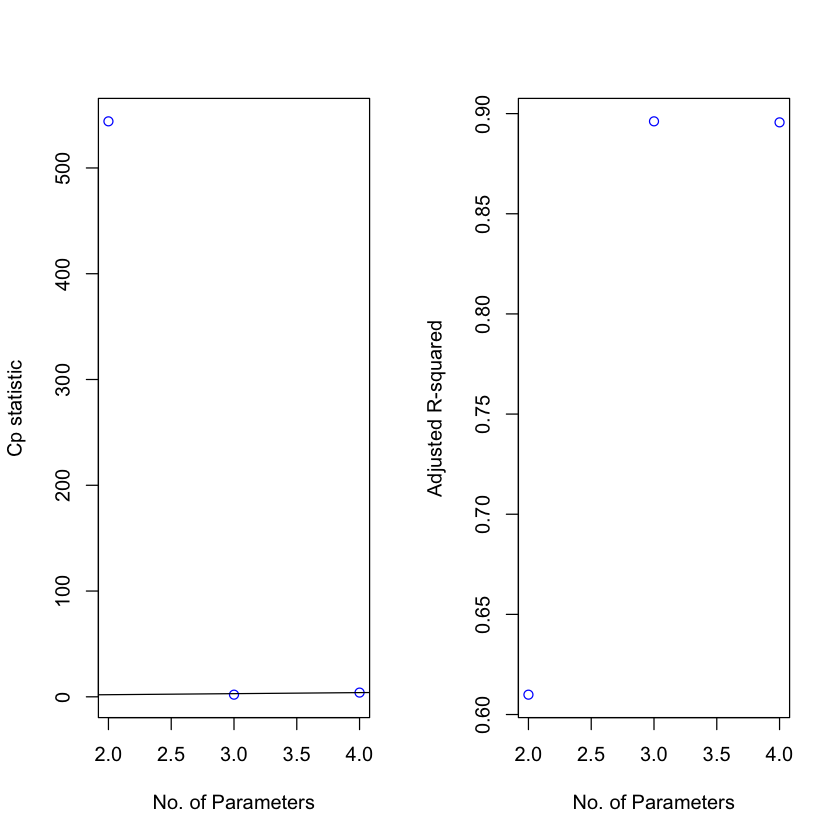

In [17]:
# Plot C_p and adjusted R^2 values
par(mfrow=c(1,2))
plot(2:4, summary(best.subset)$cp, xlab="No. of Parameters",
     ylab="Cp statistic", col="blue")
abline(0,1)
plot(2:4, summary(best.subset)$adjr2, xlab="No. of Parameters",
     ylab="Adjusted R-squared", col="blue")

From Cp values and adjusted R2 values, the model with 2 explanatory variables looks best (TV and radio).
This matches the linear model chosen using backwards elimination. 

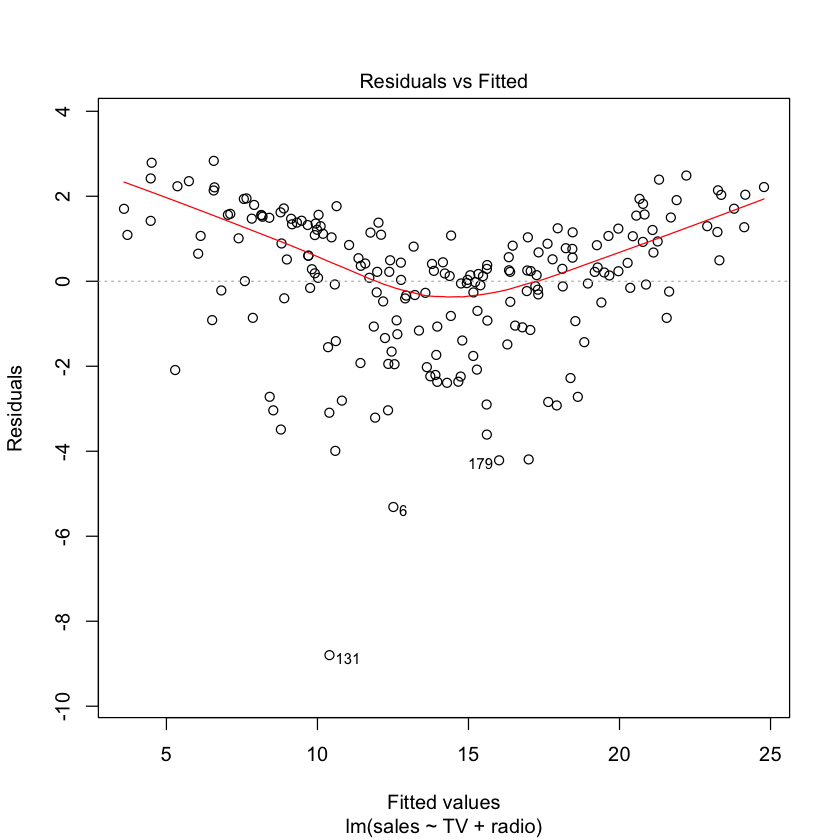

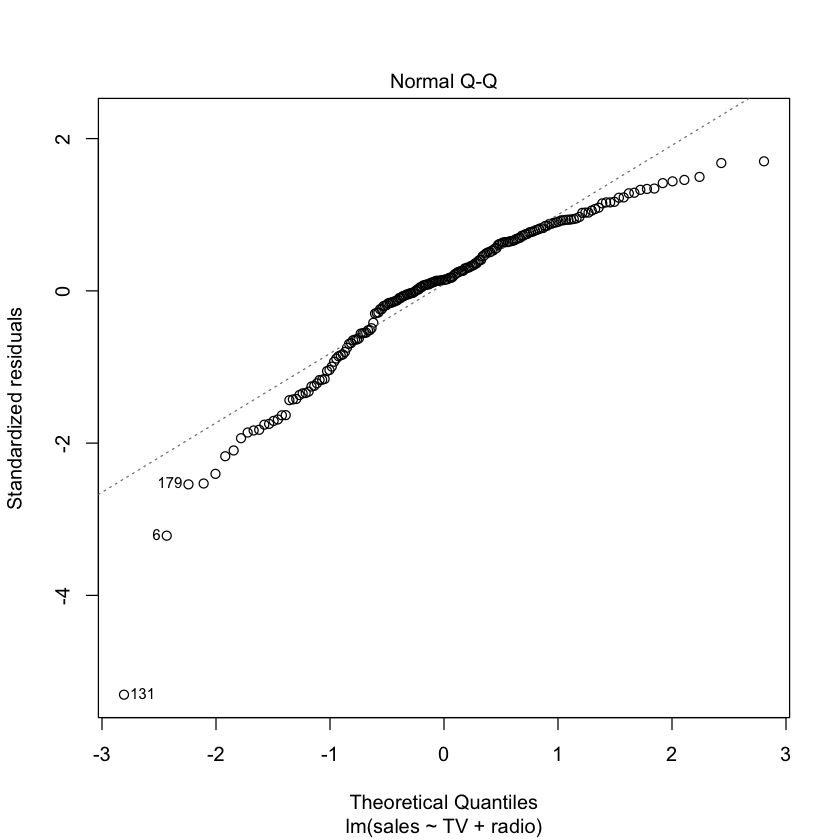

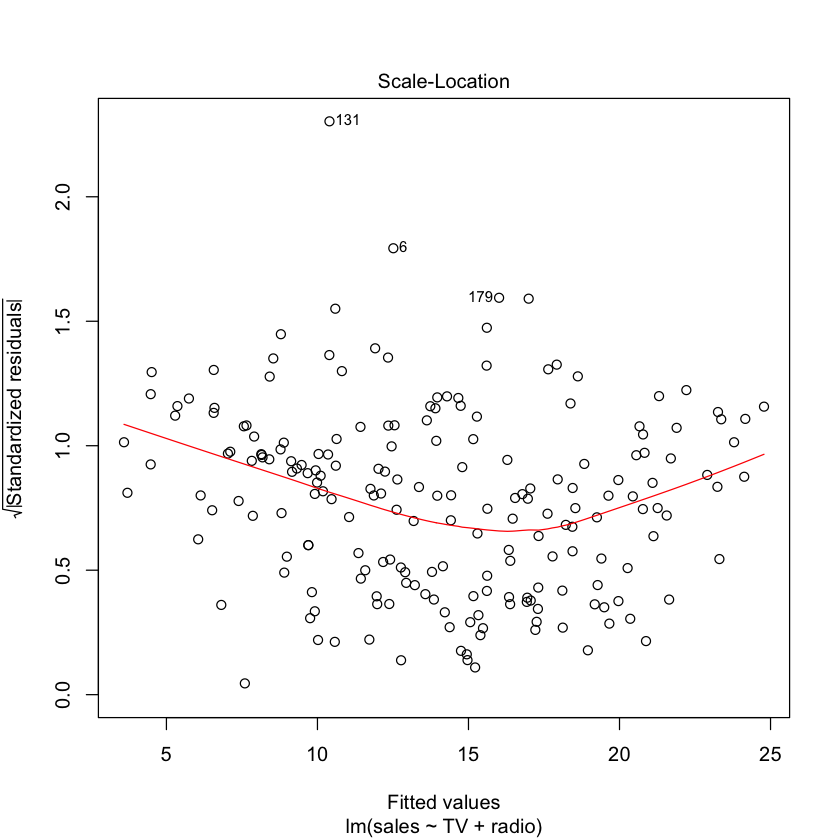

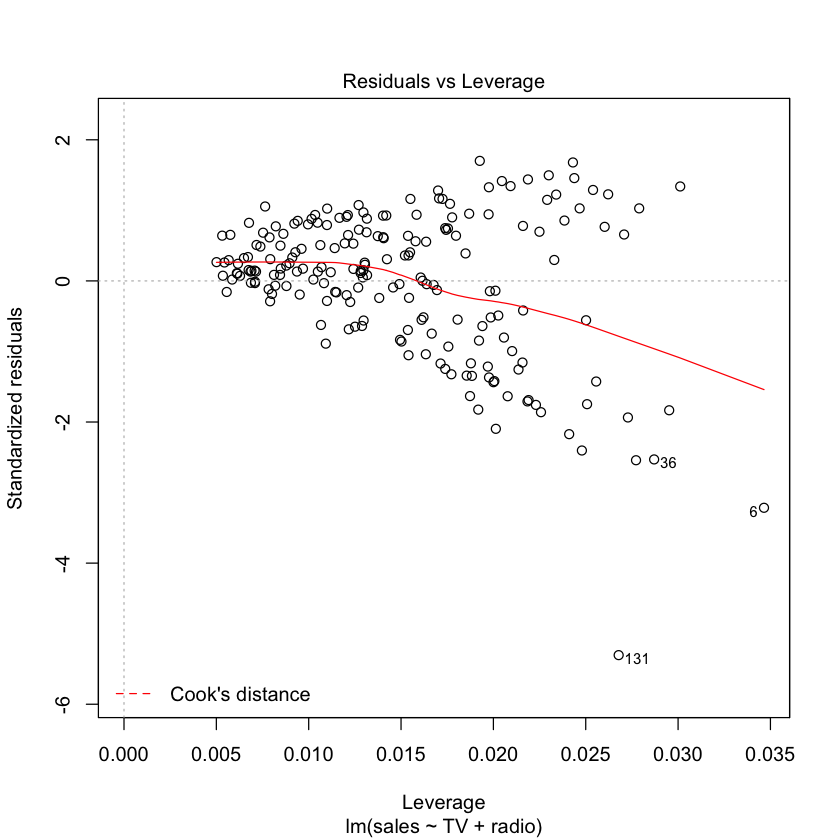

In [18]:
# Visually assess how well the linear model fits the data
plot(updatedmodel)

Residuals vs fitted plots show a quadratic relationship, indicating non-linearity. We may need higher-order polynomial terms or there are other explanatory variables that are not captured in the model.
Additionally, the QQ-plot is S-shaped, indicating that the residuals are not normally distributed. 

### Make predictions using the linear model

In [28]:
predicted <- predict(updatedmodel, test)
prediction_results <- data.frame(cbind(actual=test$sales, predicted=predicted))  
correlation_accuracy <- cor(prediction_results)

In [29]:
head(predicted)

6         9        14        15        17        20 
12.512084  3.709379  8.810951 18.444668 12.903865 14.153846

In [30]:
head(prediction_results)

,actual,predicted
6,7.2,12.512084
9,4.8,3.709379
14,9.7,8.810951
15,19.0,18.444668
17,12.5,12.903865
20,14.6,14.153846


In [31]:
correlation_accuracy

,actual,predicted
actual,1.0000000,0.9482913
predicted,0.9482913,1.0000000


### Adding interaction
We can try adding interaction between the two explanatory variables and see if the interaction is significant.

In [20]:
model_with_interaction <- lm(sales ~ TV + radio + TV * radio, data = train)
summary(model_with_interaction)


Call:
lm(formula = sales ~ TV + radio + TV * radio, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3726 -0.3295  0.1492  0.5560  1.4679 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.998e+00  3.252e-01  21.516  < 2e-16 ***
TV          1.799e-02  1.930e-03   9.324 2.74e-16 ***
radio       2.353e-02  1.149e-02   2.049   0.0424 *  
TV:radio    1.099e-03  6.646e-05  16.543  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9636 on 136 degrees of freedom
Multiple R-squared:  0.9655,	Adjusted R-squared:  0.9648 
F-statistic:  1269 on 3 and 136 DF,  p-value: < 2.2e-16


The p-value of the interaction beteen TV and radio is less than alpha, indicating that the interaction is significant given the other variables in the model.

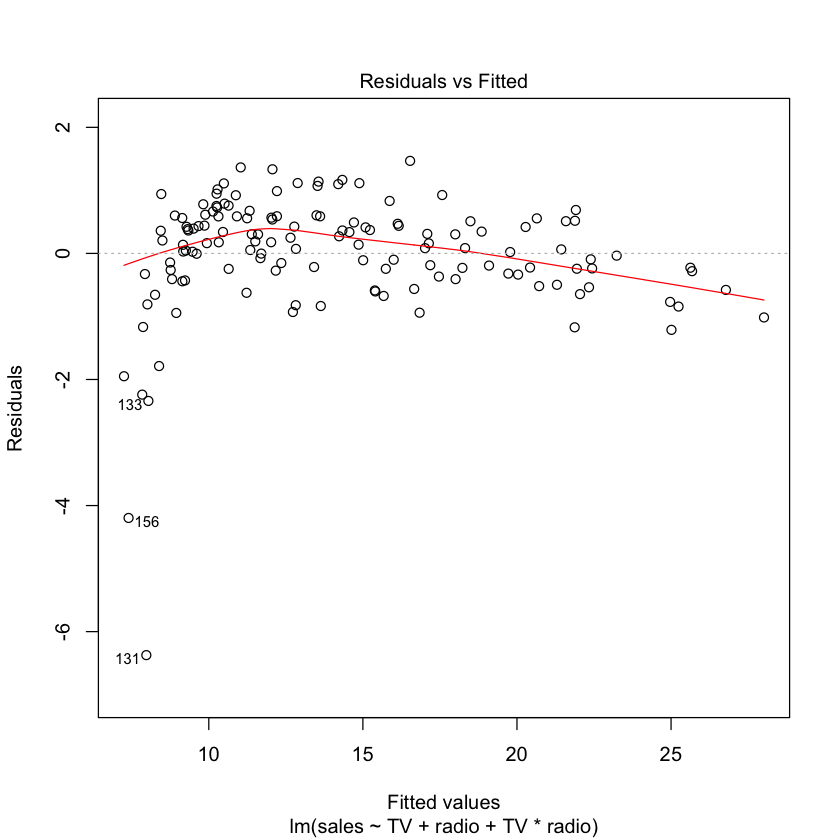

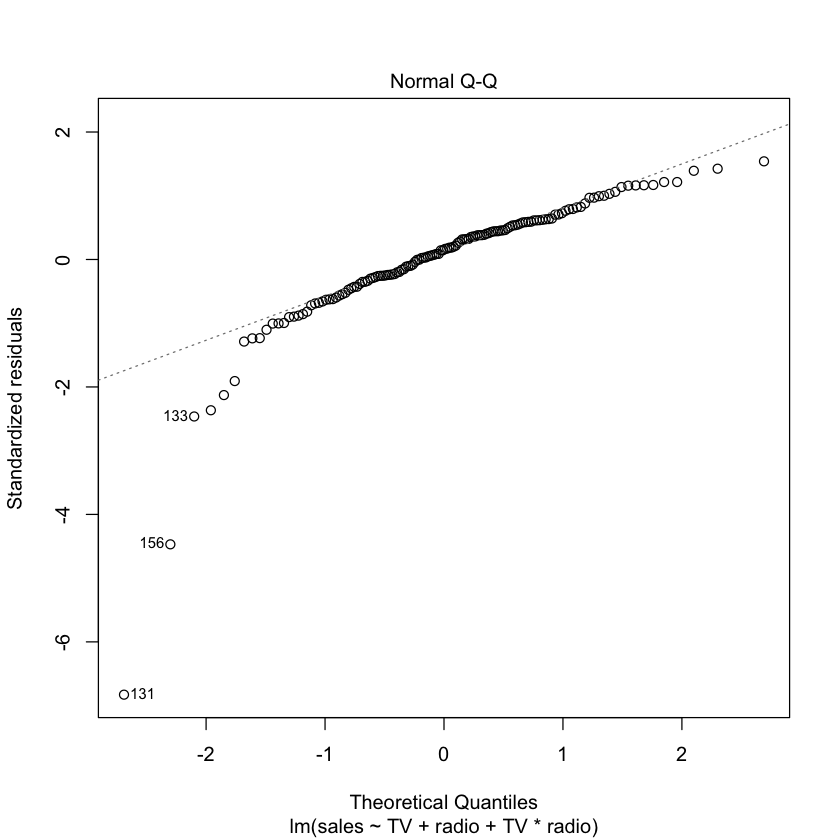

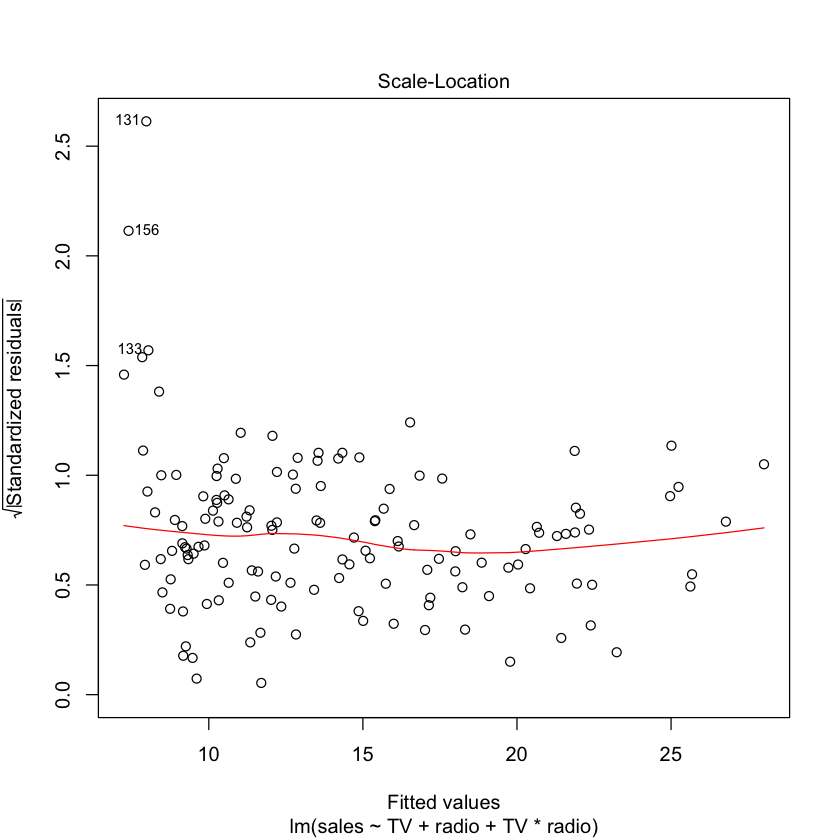

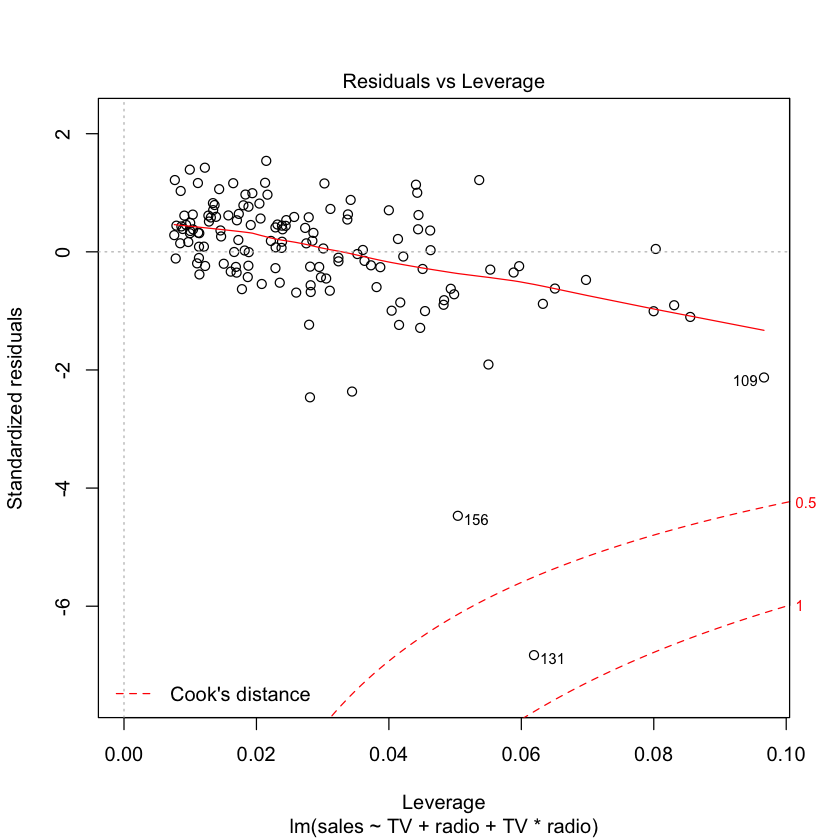

In [21]:
# Visually assess how well the linear model with interaction fits the data
plot(model_with_interaction)

The new residuals vs fitted plot shows less of a quadratic relation than the model without interaction.
The QQ-plot is U-shaped, so transformation of the response (sales) may help with normality of the residuals.

In [22]:
# Make new predictions
predicted2 <- predict(model_with_interaction, test)
prediction_results2 <- data.frame(cbind(actual=test$sales, predicted=predicted2))  
correlation_accuracy2 <- cor(prediction_results2)

In [32]:
head(predicted2)

6         9        14        15        17        20 
 8.772657  7.221613  9.745232 18.825922 11.806790 14.080420

In [33]:
head(prediction_results2)

,actual,predicted
6,7.2,8.772657
9,4.8,7.221613
14,9.7,9.745232
15,19.0,18.825922
17,12.5,11.806790
20,14.6,14.080420


In [34]:
correlation_accuracy2

,actual,predicted
actual,1.0000000,0.9868432
predicted,0.9868432,1.0000000
